# Implementing the Ocean Battery
Lets see if what the optimal size of the ocean battery in a system with:
- An installed Wind Farm (2002 MW)
- An connection to shore (2000 MW)
- An existing gas fired power plant (2000 MW)
- Existing PV capacity (800 MW)

An overview:

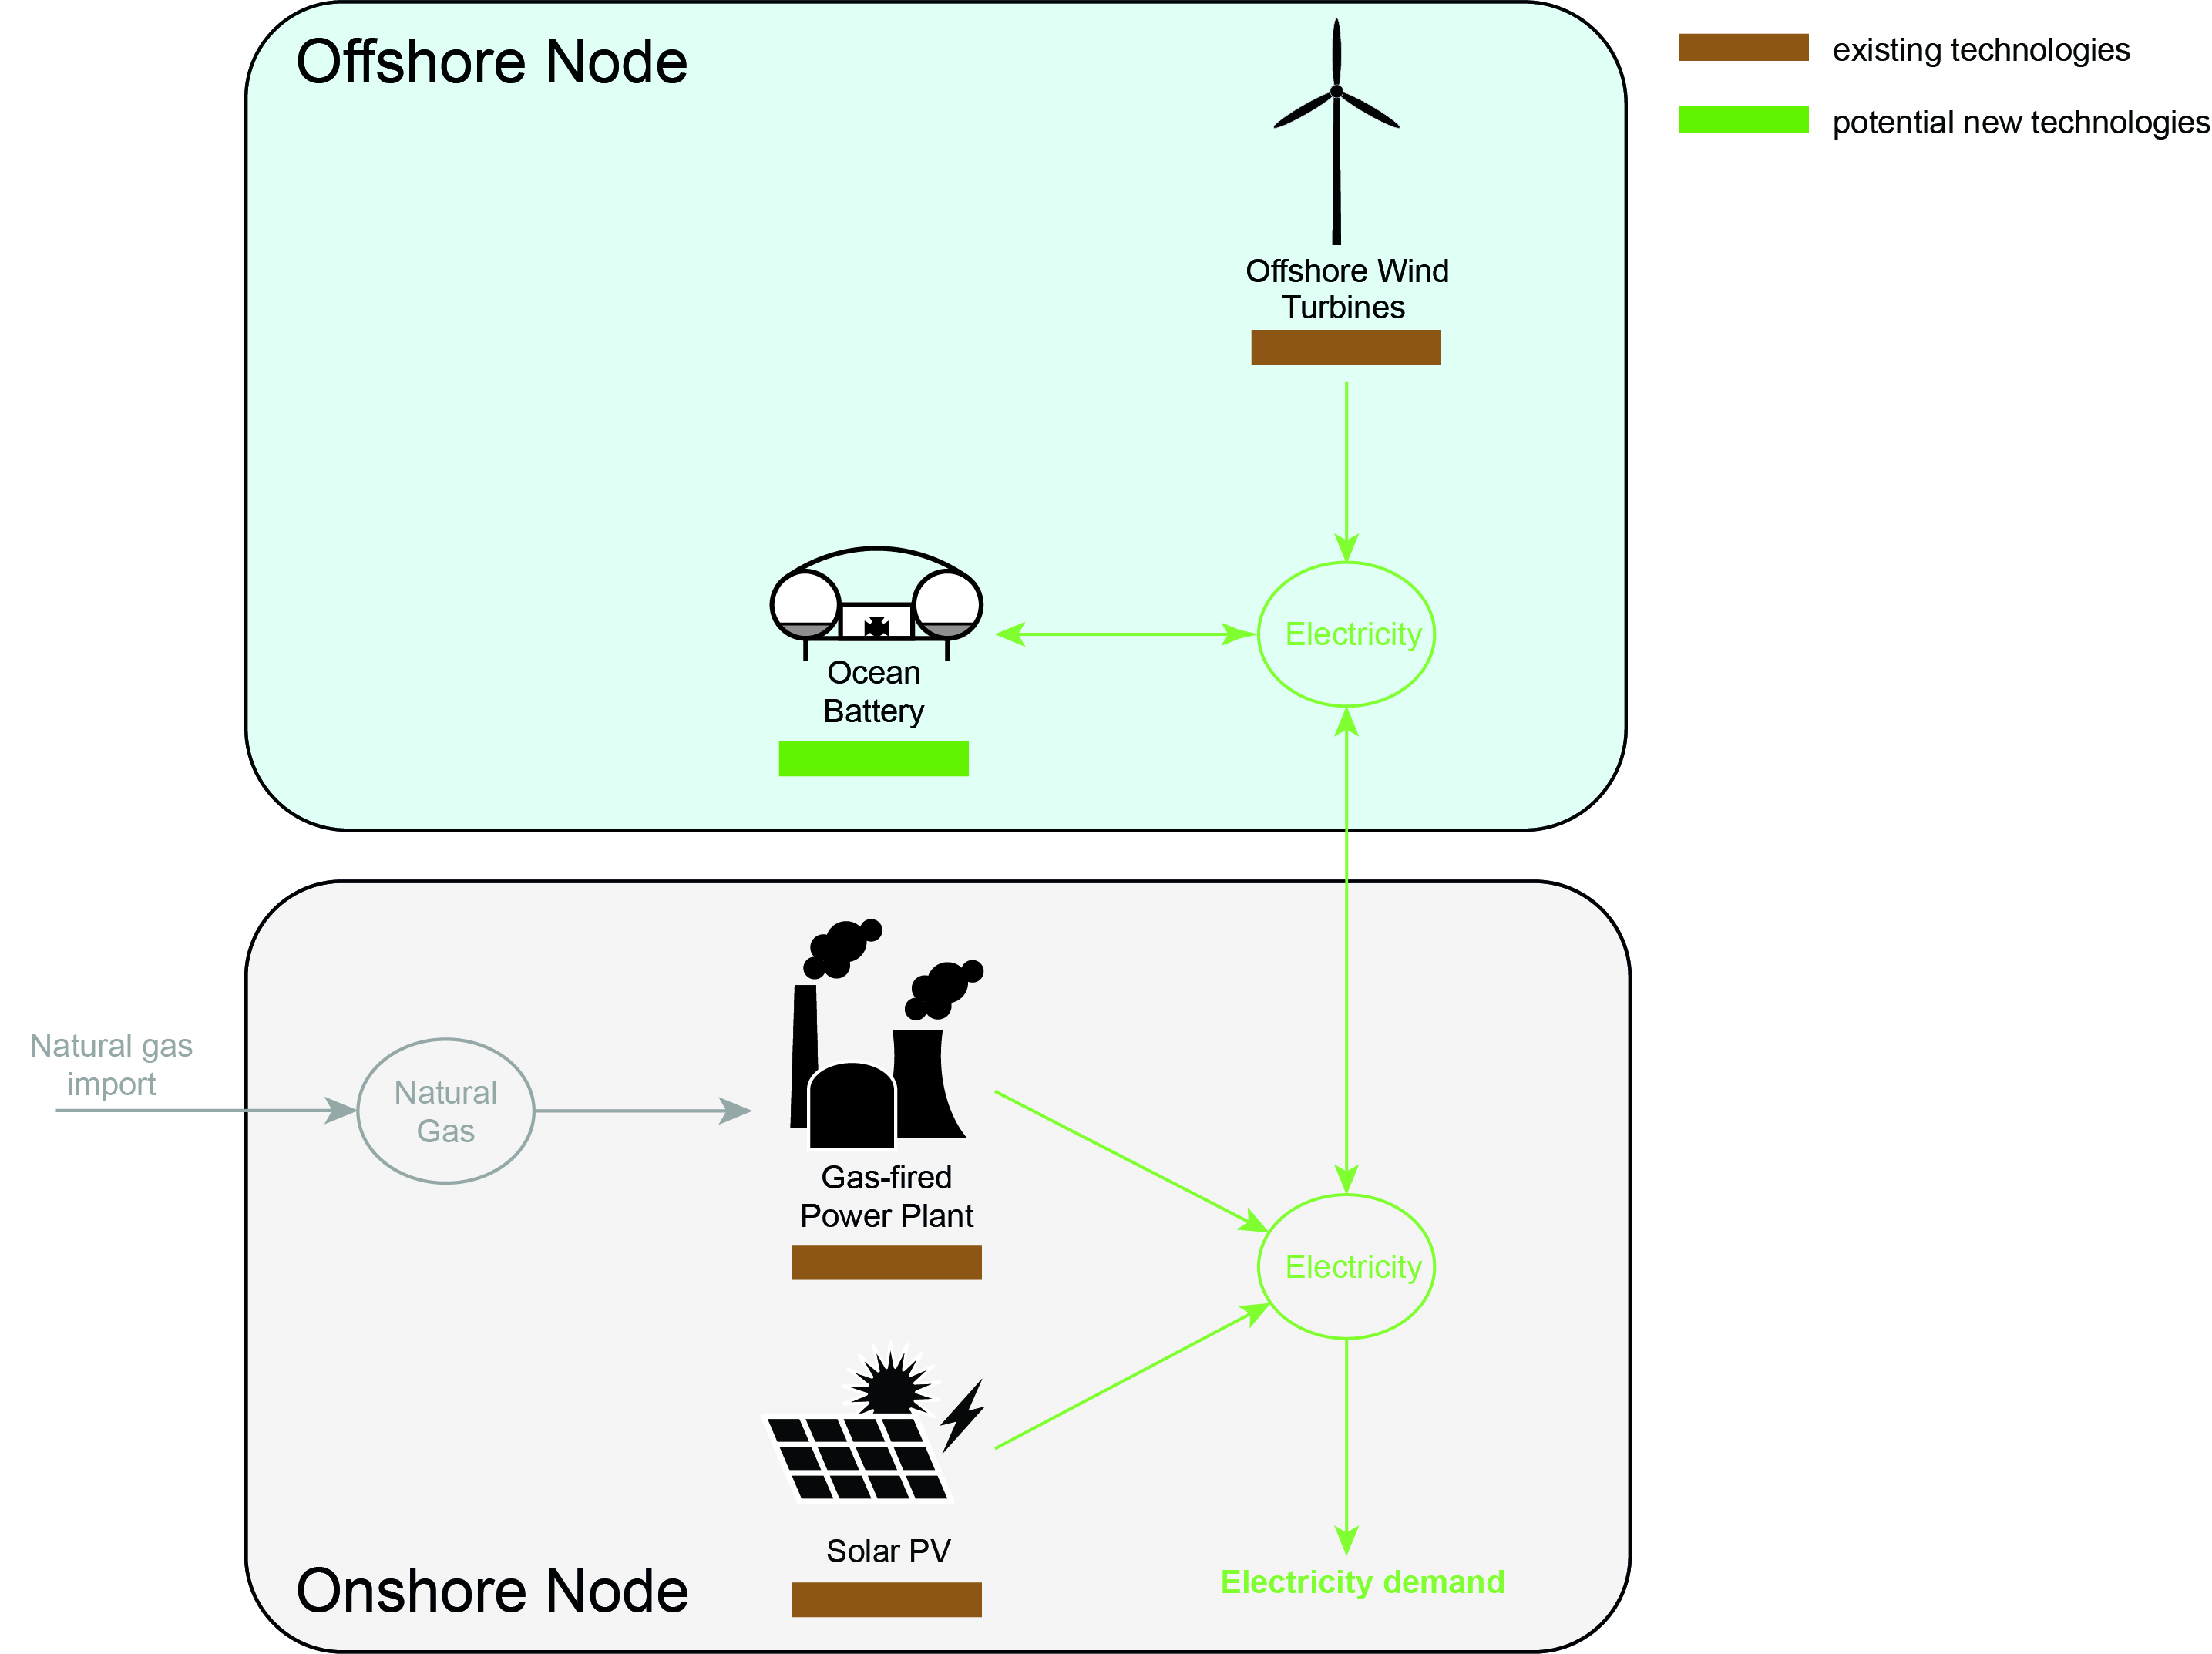

## Defining the system topology and input data

In [1]:
from src.model_configuration import ModelConfiguration
import src.data_management as dm
from src.energyhub import EnergyHub
from cases.wind_meets_gas.utilities import *

import copy
import pandas as pd
import numpy as np
from types import SimpleNamespace

topology = dm.SystemTopology()

# Time Horizon, energy carriers, nodes
topology.define_time_horizon(year=2009,start_date='01-01 00:00', end_date='12-31 23:00', resolution=1)
topology.define_carriers(['electricity', 'gas'])
topology.define_nodes(['onshore', 'offshore'])

# Technologies
topology.define_existing_technologies('offshore', {'WindTurbine_Offshore_11000': 182})
topology.define_existing_technologies('onshore', {'Photovoltaic': 800, 'PowerPlant_Gas': 2000})
topology.define_new_technologies('offshore', ['Storage_OceanBattery'])

# Electricity connection to shore
size_matrix = dm.create_empty_network_matrix(topology.nodes)
size_matrix.at['onshore', 'offshore'] = 1
size_matrix.at['offshore', 'onshore'] = 1
distance_matrix = dm.create_empty_network_matrix(topology.nodes)
distance_matrix.at['onshore', 'offshore'] = 80
distance_matrix.at['offshore', 'onshore'] = 80

topology.define_existing_network('electricityDC_int', size=size_matrix, distance=distance_matrix)

# Initialize instance of DataHandle
data = dm.DataHandle(topology)

# Set price data
carbon_price = 90
gas_price = 60

# Electricity demand
electricity_demand = pd.read_excel('./cases/wind_meets_gas/Demand.xlsx')
data.read_demand_data('onshore', 'electricity', list(electricity_demand['demand']))

# Climate data
data.read_climate_data_from_file('onshore', './data/climate_data_onshore.txt')
data.read_climate_data_from_file('offshore', './data/climate_data_offshore.txt')

# Carbon price
data.read_carbon_price_data(np.ones(len(topology.timesteps)) * carbon_price, 'tax')

# Allow for gas import for the gas power plant
gas_import_limit = 5000
data.read_import_limit_data('onshore', 'gas', np.ones(len(topology.timesteps)) * gas_import_limit)

# Specify gas price
data.read_import_price_data('onshore', 'gas', np.ones(len(topology.timesteps)) * gas_price)

# Read technology and network data
data.read_technology_data('./cases/wind_meets_gas/Technology_Data/')
data.read_network_data('./cases/wind_meets_gas/Network_Data/')

## Optimization

In [2]:
# Load configuration
configuration = ModelConfiguration()
configuration.reporting.save_path = './userData/OceanBattery'

# Solve the model
energyhub = EnergyHub(data, configuration)
results = energyhub.quick_solve()

____________________________________________________________
Reading in data...
Reading in data completed in 0 s
____________________________________________________________
____________________________________________________________
Constructing Model...
____________________________________________________________
--- Adding Networks... ---
	 - Adding Network electricityDC_int_existing
		Big-M Transformation...
		Big-M Transformation completed in 8 s
____________________________________________________________
--- Adding Node onshore... ---
	 - Adding Technology Photovoltaic
	 - Adding Technology PowerPlant_Gas
____________________________________________________________
--- Adding Node offshore... ---
	 - Adding Technology Storage_OceanBattery
	 - Adding Technology WindTurbine_Offshore_11000
Constructing model completed in 28 s
____________________________________________________________
Constructing balances...
Constructing balances completed in 4 s
________________________________

## Plotting

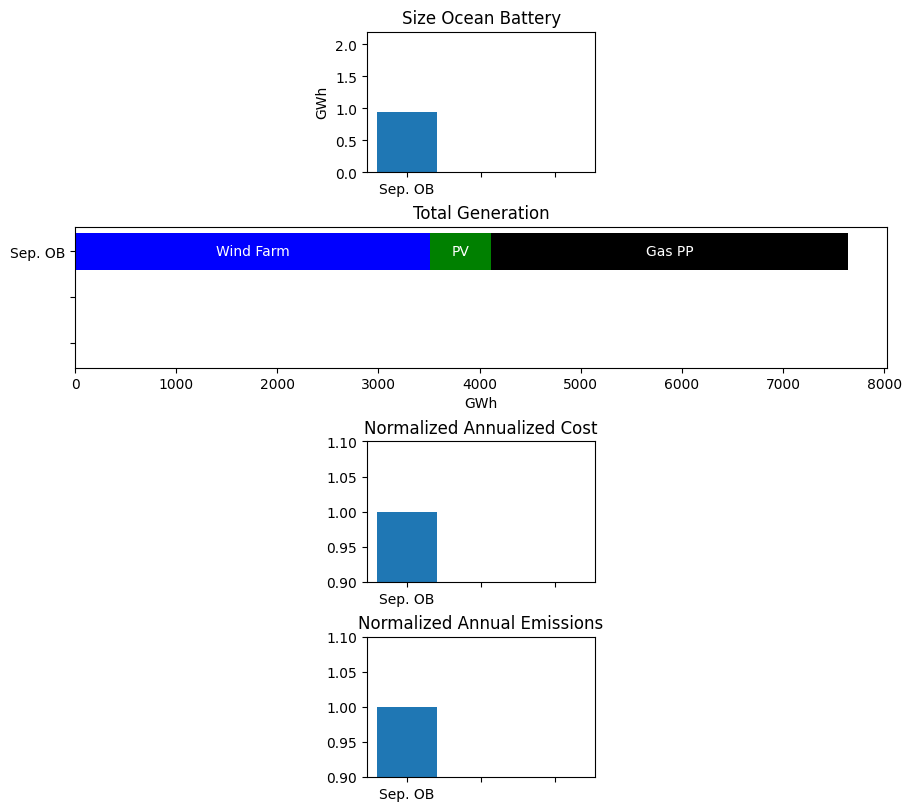

In [3]:
p_res = PlotResults_2(3)
p_res.add_result(results, 'Sep. OB')
p_res.plot_result()

# Governance does not permit storage offshore...

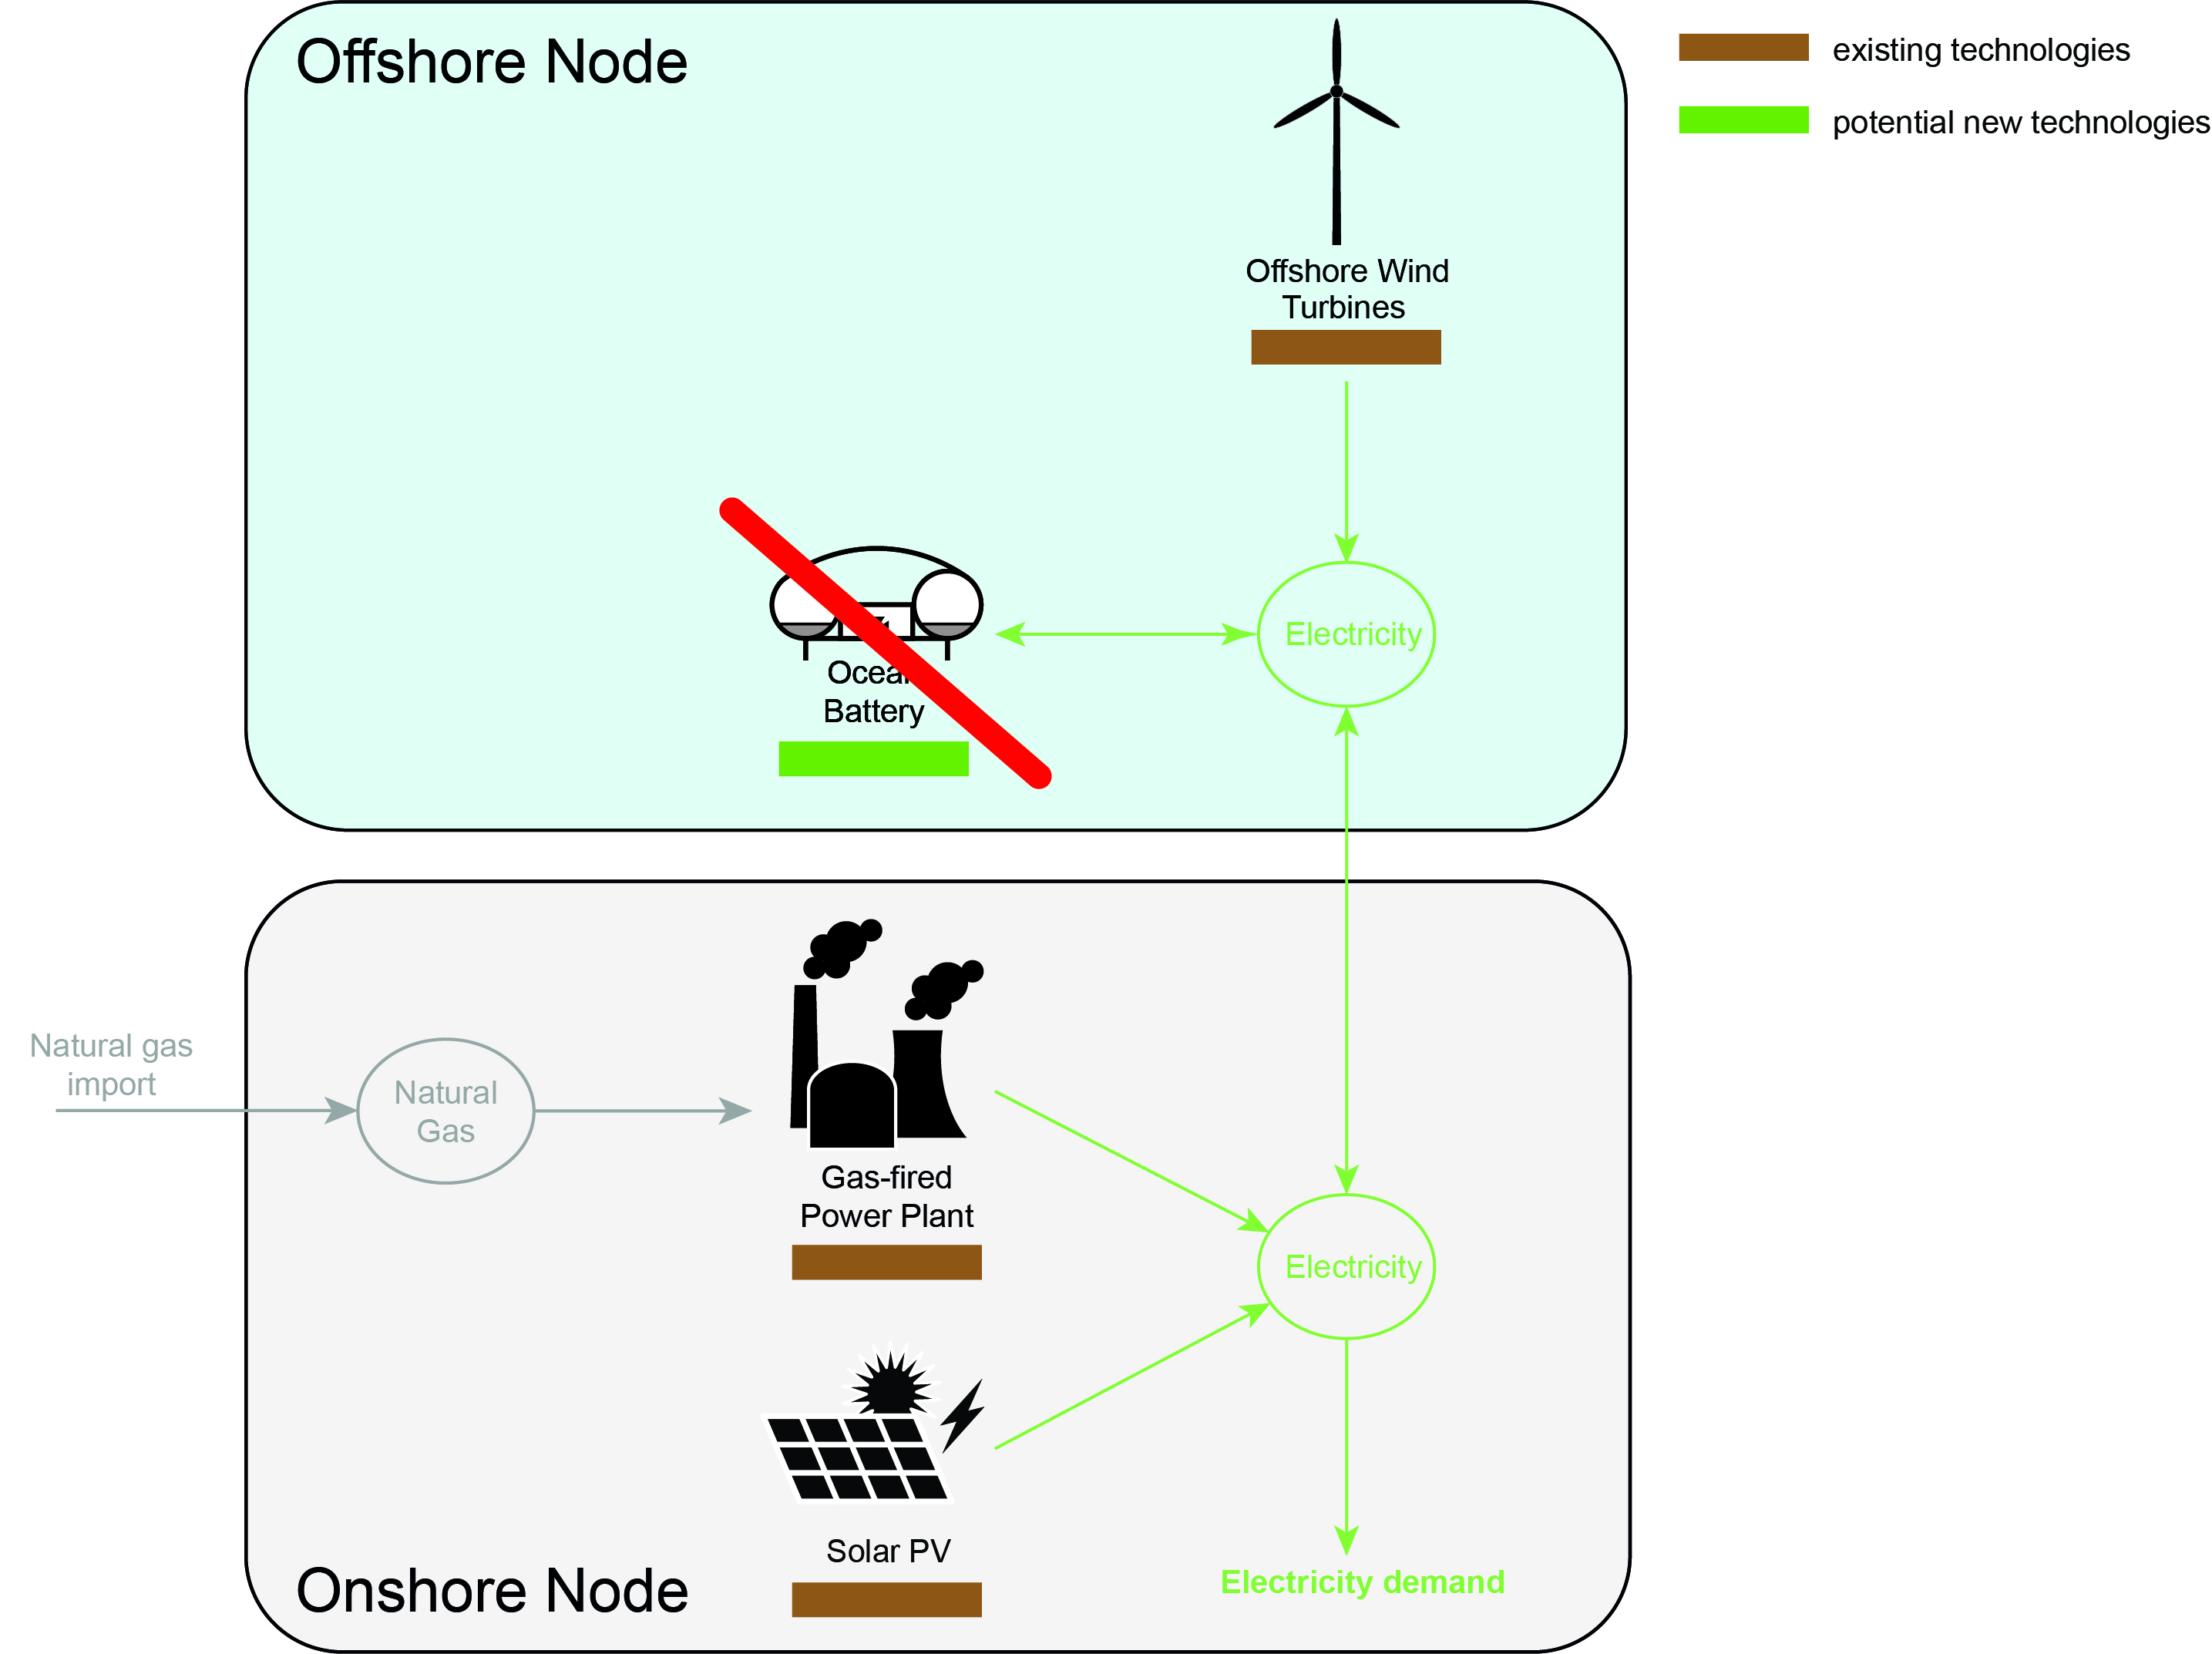

## Changing the data
Removing the new technologies from the offshore node

In [4]:
# Remove all new technologies from offshore node
topology.define_new_technologies('offshore', [])
data.topology = topology

# Read technology and network data
data.read_technology_data('./cases/wind_meets_gas/Technology_Data/')
data.read_network_data('./cases/wind_meets_gas/Network_Data/')

## Optimization

In [5]:
energyhub = EnergyHub(data, configuration)
results = energyhub.quick_solve()

____________________________________________________________
Reading in data...
Reading in data completed in 0 s
____________________________________________________________
____________________________________________________________
Constructing Model...
____________________________________________________________
--- Adding Networks... ---
	 - Adding Network electricityDC_int_existing
		Big-M Transformation...
		Big-M Transformation completed in 17 s
____________________________________________________________
--- Adding Node onshore... ---
	 - Adding Technology Photovoltaic
	 - Adding Technology PowerPlant_Gas
____________________________________________________________
--- Adding Node offshore... ---
	 - Adding Technology WindTurbine_Offshore_11000
Constructing model completed in 33 s
____________________________________________________________
Constructing balances...
Constructing balances completed in 3 s
____________________________________________________________
Solving Model

## Plotting

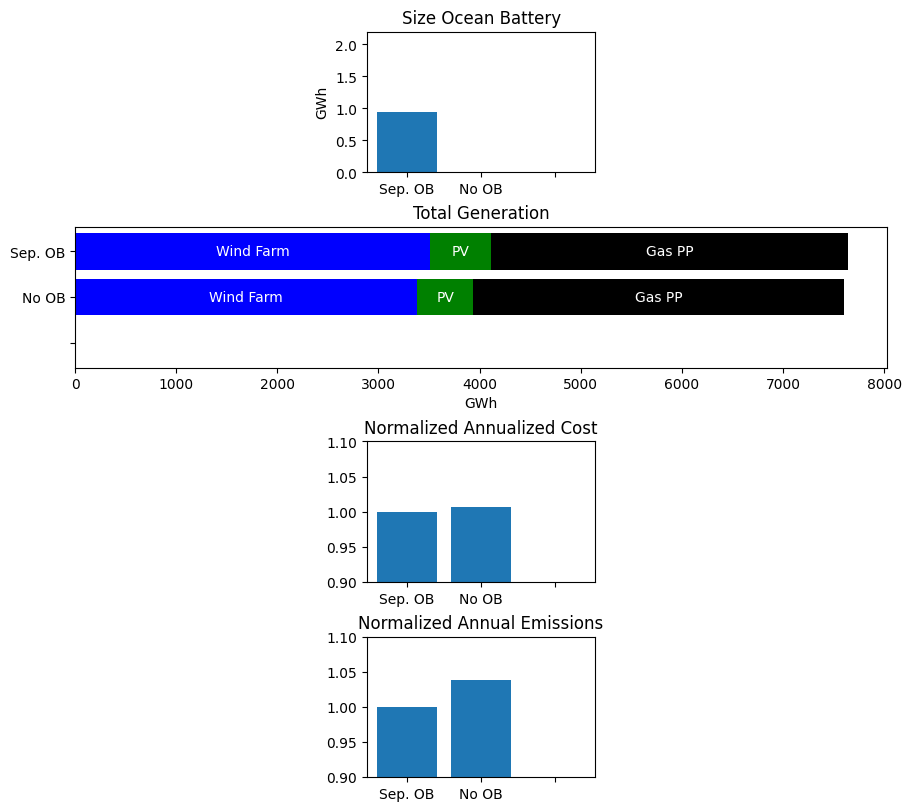

In [6]:
p_res.add_result(results, 'No OB')
p_res.plot_result()

# Regulating storage systems offshore
It is not clear, how storage systems can be connected. Two possible cases are:
- Separate from Wind Farm (done before)
- Within Wind Farm (Generator to Storage Connection)

To model the second case, we allow only for a unidirectional flow in the transmission cable.
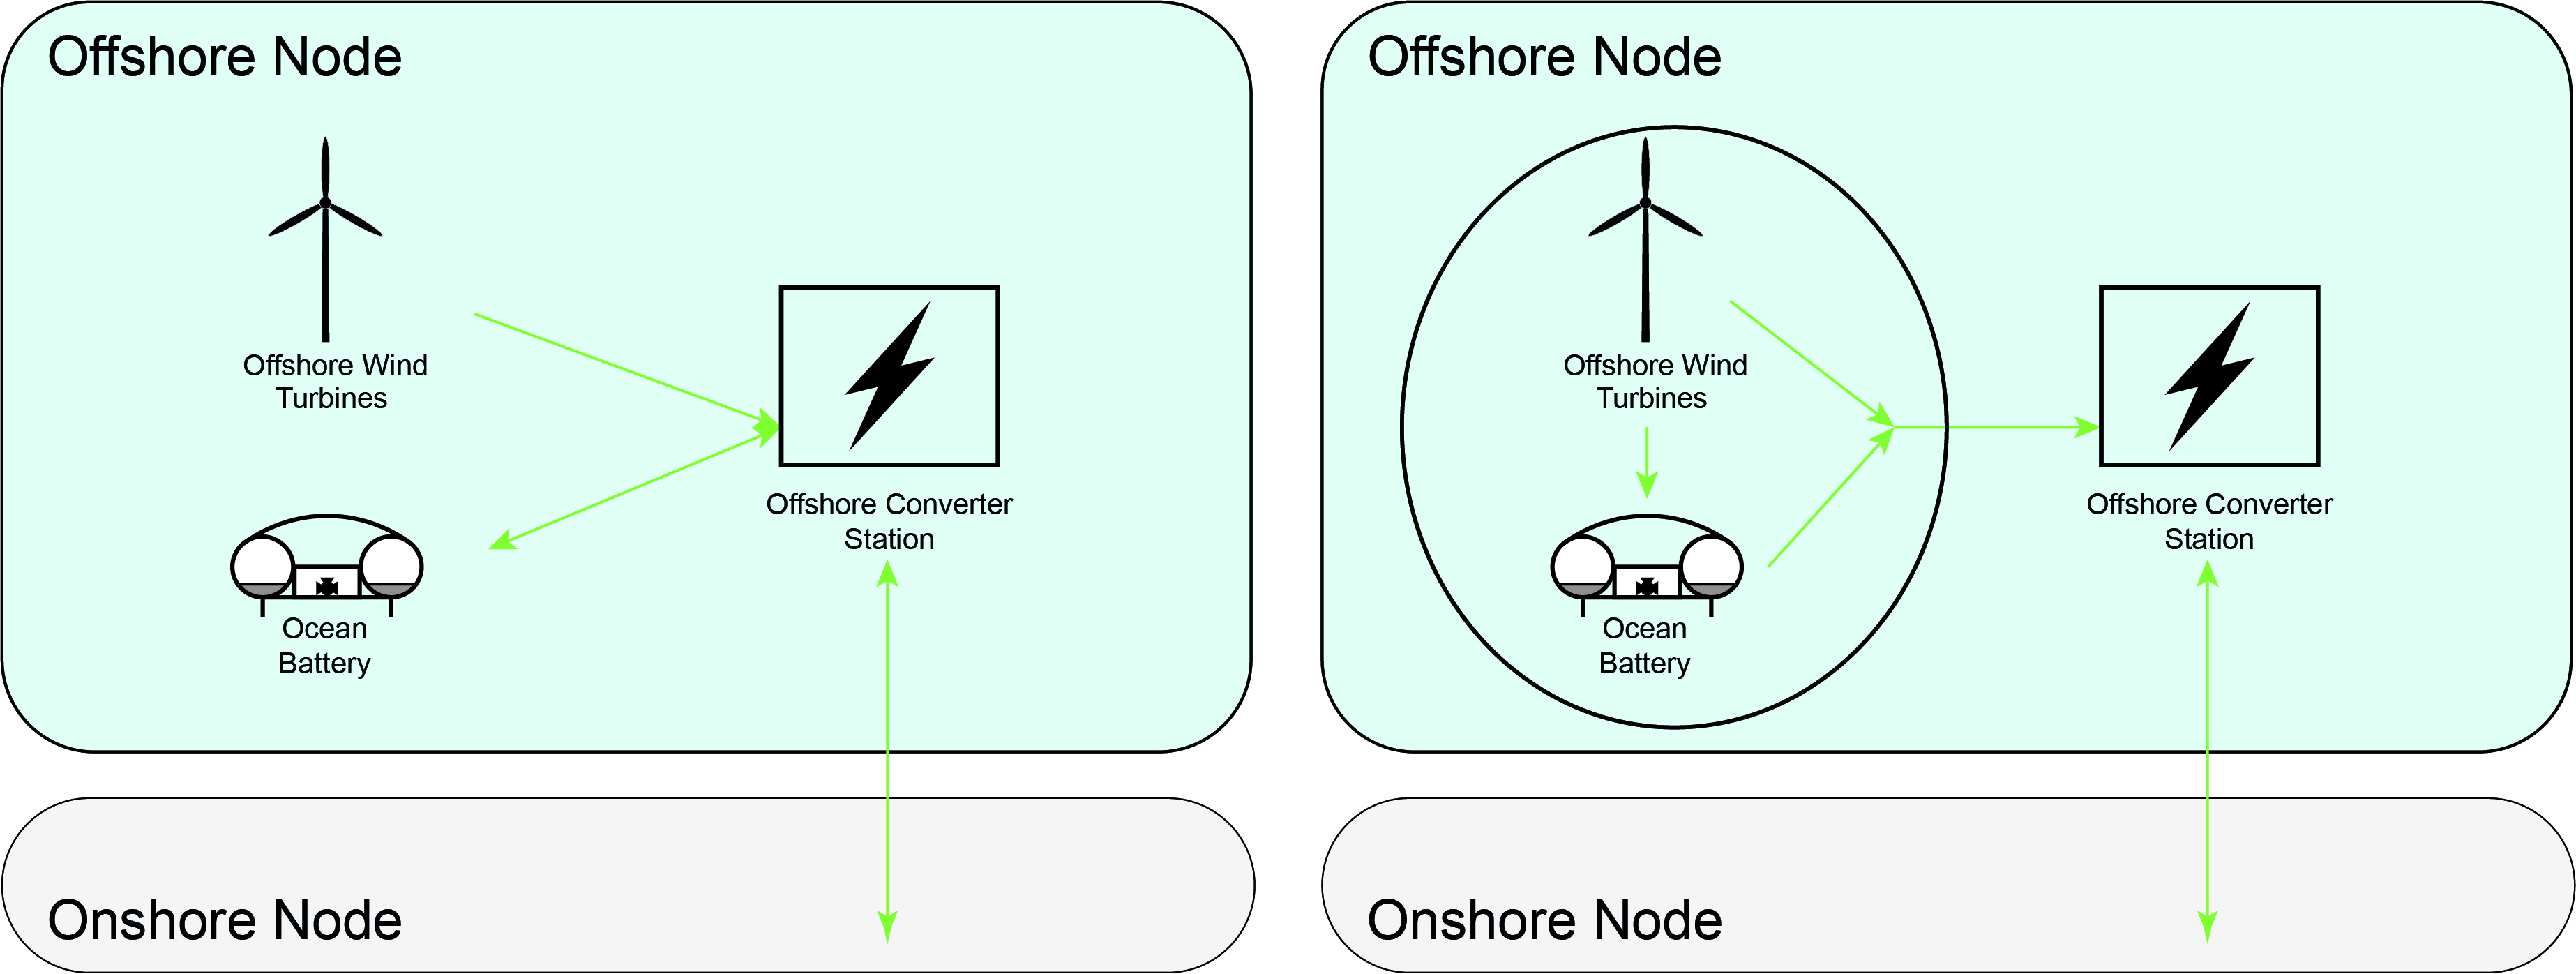

## Changing the data

In [7]:
# Change the connection properties
topology.networks_existing = {}
data.network_data = {}
topology.define_new_technologies('offshore', ['Storage_OceanBattery'])
size_matrix = dm.create_empty_network_matrix(topology.nodes)
size_matrix.at['onshore', 'offshore'] = 0
size_matrix.at['offshore', 'onshore'] = 1
topology.define_existing_network('electricityDC_uni', size=size_matrix, distance=distance_matrix)
data.topology = topology

# Read technology and network data
data.read_technology_data('./cases/wind_meets_gas/Technology_Data/')
data.read_network_data('./cases/wind_meets_gas/Network_Data/')

## Optimization

In [8]:
energyhub = EnergyHub(data, configuration)
results = energyhub.quick_solve()

____________________________________________________________
Reading in data...
Reading in data completed in 0 s
____________________________________________________________
____________________________________________________________
Constructing Model...
____________________________________________________________
--- Adding Networks... ---
	 - Adding Network electricityDC_uni_existing
____________________________________________________________
--- Adding Node onshore... ---
	 - Adding Technology Photovoltaic
	 - Adding Technology PowerPlant_Gas
____________________________________________________________
--- Adding Node offshore... ---
	 - Adding Technology Storage_OceanBattery
	 - Adding Technology WindTurbine_Offshore_11000
Constructing model completed in 19 s
____________________________________________________________
Constructing balances...
Constructing balances completed in 4 s
____________________________________________________________
Solving Model...
Set parameter TimeLi

## Plotting

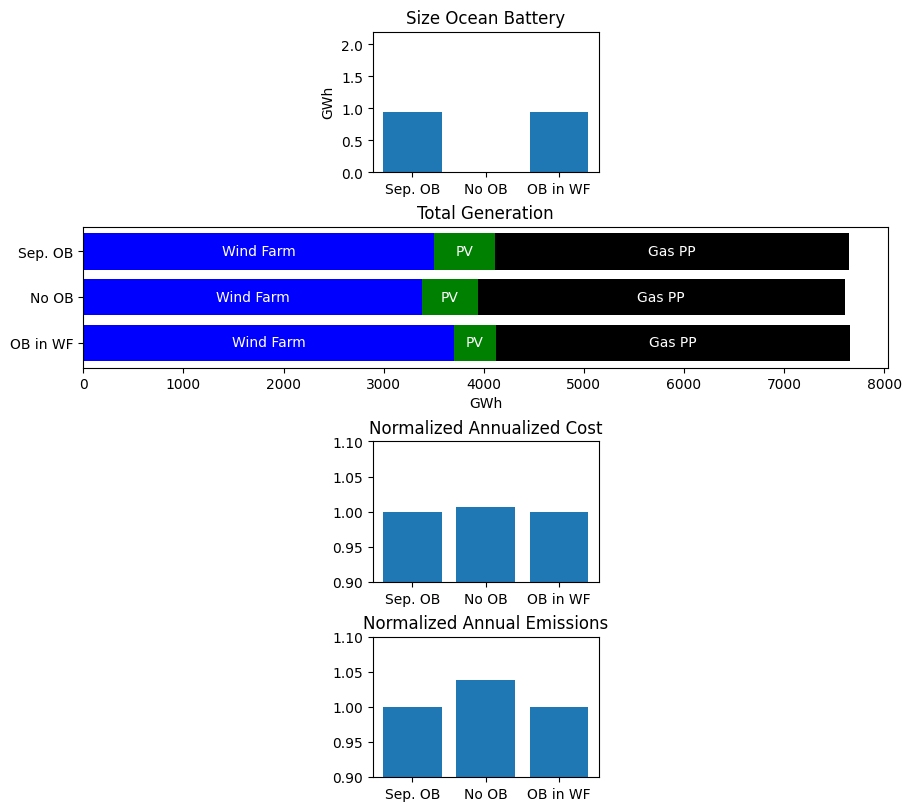

In [9]:
p_res.add_result(results, 'OB in WF')
p_res.plot_result()

# Regulation of offshore storage systems in high-share RES systems
What is the impact if we have significantly more PV installed onshore?

## Define data and optimize for both cases (uni-directional and bi-directional)

In [10]:
# Birectional case
p_res = PlotResults_2(2)
topology.define_existing_technologies('offshore', {'WindTurbine_Offshore_11000': 182})
topology.define_existing_technologies('onshore', {'Photovoltaic': 1600, 'PowerPlant_Gas': 2000})
topology.define_new_technologies('offshore', ['Storage_OceanBattery'])

# Electricity connection to shore
size_matrix = dm.create_empty_network_matrix(topology.nodes)
size_matrix.at['onshore', 'offshore'] = 1
size_matrix.at['offshore', 'onshore'] = 1
distance_matrix = dm.create_empty_network_matrix(topology.nodes)
distance_matrix.at['onshore', 'offshore'] = 80
distance_matrix.at['offshore', 'onshore'] = 80
topology.define_existing_network('electricityDC_int', size=size_matrix, distance=distance_matrix)
data.topology = topology

# Read technology and network data
data.read_technology_data('./cases/wind_meets_gas/Technology_Data/')
data.read_network_data('./cases/wind_meets_gas/Network_Data/')

# Solve the model
energyhub = EnergyHub(data, configuration)
results = energyhub.quick_solve()
p_res.add_result(results, 'OB sep.')

____________________________________________________________
Reading in data...
Reading in data completed in 0 s
____________________________________________________________
____________________________________________________________
Constructing Model...
____________________________________________________________
--- Adding Networks... ---
	 - Adding Network electricityDC_uni_existing
	 - Adding Network electricityDC_int_existing
		Big-M Transformation...
		Big-M Transformation completed in 12 s
____________________________________________________________
--- Adding Node onshore... ---
	 - Adding Technology Photovoltaic
	 - Adding Technology PowerPlant_Gas
____________________________________________________________
--- Adding Node offshore... ---
	 - Adding Technology Storage_OceanBattery
	 - Adding Technology WindTurbine_Offshore_11000
Constructing model completed in 31 s
____________________________________________________________
Constructing balances...
Constructing balances co

In [11]:
# Unidirectional case
# Electricity connection to shore
size_matrix = dm.create_empty_network_matrix(topology.nodes)
size_matrix.at['onshore', 'offshore'] = 0
size_matrix.at['offshore', 'onshore'] = 1
distance_matrix = dm.create_empty_network_matrix(topology.nodes)
distance_matrix.at['onshore', 'offshore'] = 80
distance_matrix.at['offshore', 'onshore'] = 80
topology.networks_existing = {}

data.network_data = {}
topology.define_existing_network('electricityDC_uni', size=size_matrix, distance=distance_matrix)
data.topology = topology

# Read technology and network data
data.read_technology_data('./cases/wind_meets_gas/Technology_Data/')
data.read_network_data('./cases/wind_meets_gas/Network_Data/')

# Solve the model
energyhub = EnergyHub(data, configuration)
results = energyhub.quick_solve()
p_res.add_result(results, 'OB in WF')

____________________________________________________________
Reading in data...
Reading in data completed in 0 s
____________________________________________________________
____________________________________________________________
Constructing Model...
____________________________________________________________
--- Adding Networks... ---
	 - Adding Network electricityDC_uni_existing
____________________________________________________________
--- Adding Node onshore... ---
	 - Adding Technology Photovoltaic
	 - Adding Technology PowerPlant_Gas
____________________________________________________________
--- Adding Node offshore... ---
	 - Adding Technology Storage_OceanBattery
	 - Adding Technology WindTurbine_Offshore_11000
Constructing model completed in 17 s
____________________________________________________________
Constructing balances...
Constructing balances completed in 3 s
____________________________________________________________
Solving Model...
Set parameter TimeLi

## Plotting

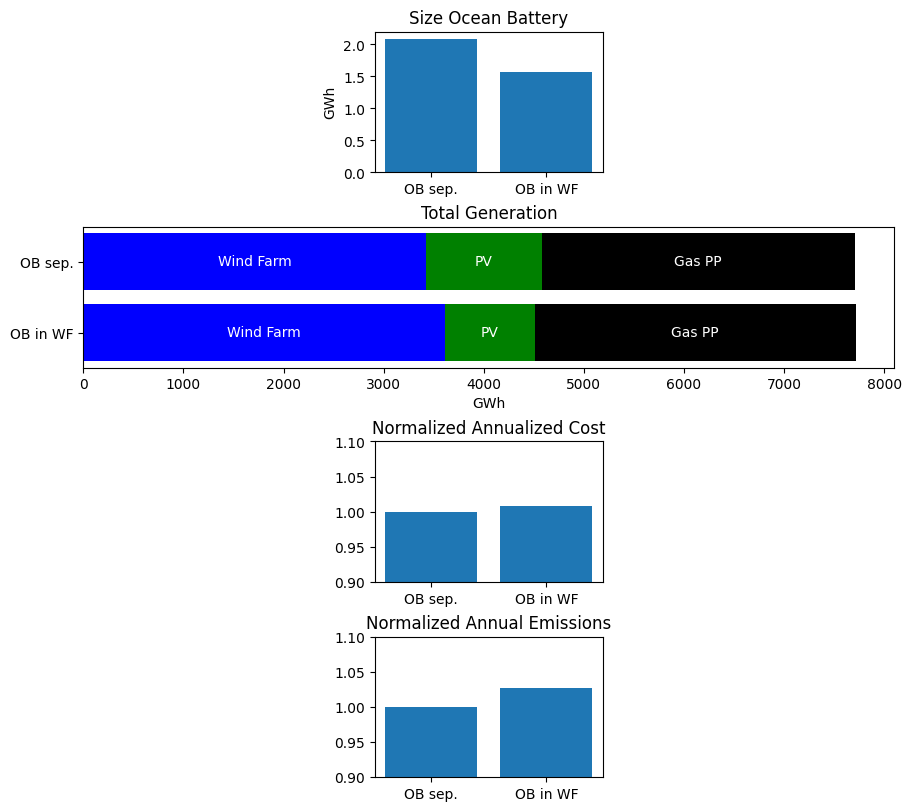

In [12]:
p_res.plot_result()